# Text Classification ML experiment

Developing a text classification model to categorize news articles (from 8 categories of the 20 Newsgroups dataset). Using algorithms like Logistic Regression, Random Forest, and SVM, and evaluating performance with Accuracy, Precision, Recall, and F1-score. Text preprocessing includes TF-IDF and n-grams.

## Installing packages


In [4]:
%pip install scikit-learn pandas numpy matplotlib seaborn wordcloud joblib


Note: you may need to restart the kernel to use updated packages.


## Importing libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import pickle
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from wordcloud import WordCloud

## Setup

In [6]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Get the data

In [7]:
categories = [
    'alt.atheism',             
    'comp.graphics',           
    'comp.os.ms-windows.misc', 
    'comp.sys.ibm.pc.hardware',
    'rec.autos',                
    'rec.motorcycles',          
    'sci.space',                
    'talk.politics.misc'       
]

# training set
newsgroups_train = fetch_20newsgroups(
    subset='train', 
    categories=categories,
    shuffle=True, 
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

# test set
newsgroups_test = fetch_20newsgroups(
    subset='test', 
    categories=categories,
    shuffle=True, 
    random_state=42,
    remove=('headers', 'footers', 'quotes')
)

# Analyze and visualize the data

In [8]:
text_lengths = [len(text.split()) for text in newsgroups_train.data]
char_lengths = [len(text) for text in newsgroups_train.data]

print("BASIC STATISTICS:")
print(f"   • Average text length: {np.mean(text_lengths):.0f} words")
print(f"   • Median text length: {np.median(text_lengths):.0f} words")
print(f"   • Shortest text: {np.min(text_lengths)} words")
print(f"   • Longest text: {np.max(text_lengths)} words")
print(f"   • Average character length: {np.mean(char_lengths):.0f} characters")

# Category distribution
category_counts = Counter(newsgroups_train.target)

print(f"\nCATEGORY DISTRIBUTION:")
print(f"{'Category':30} {'Number of texts':>15} {'Percent':>10}")
print("-" * 60)

for i, count in category_counts.items():
    category_name = newsgroups_train.target_names[i]
    percentage = (count / len(newsgroups_train.data)) * 100
    print(f"{category_name:30} {count:>15} {percentage:>9.1f}%")

BASIC STATISTICS:
   • Average text length: 162 words
   • Median text length: 74 words
   • Shortest text: 0 words
   • Longest text: 9109 words
   • Average character length: 1183 characters

CATEGORY DISTRIBUTION:
Category                       Number of texts    Percent
------------------------------------------------------------
rec.motorcycles                            598      13.3%
rec.autos                                  594      13.2%
alt.atheism                                480      10.7%
comp.graphics                              584      13.0%
talk.politics.misc                         465      10.3%
comp.os.ms-windows.misc                    591      13.1%
sci.space                                  593      13.2%
comp.sys.ibm.pc.hardware                   590      13.1%


In [9]:
# text length analysis
text_lengths_by_category = {}
for i, category in enumerate(newsgroups_train.target_names):
    category_indices = [idx for idx, target in enumerate(newsgroups_train.target) if target == i]
    category_lengths = [text_lengths[idx] for idx in category_indices]
    text_lengths_by_category[category.split('.')[-1]] = category_lengths

# Length statistics per category
print(f"AVERAGE TEXT LENGTH PER CATEGORY:")
print(f"{'Category':<15} {'Average':<10} {'Median':<10} {'Min':<8} {'Max':<8}")
print("-" * 55)

for category, lengths in text_lengths_by_category.items():
    print(f"{category:<15} {np.mean(lengths):<10.1f} {np.median(lengths):<10.1f} "
          f"{np.min(lengths):<8} {np.max(lengths):<8}")


AVERAGE TEXT LENGTH PER CATEGORY:
Category        Average    Median     Min      Max     
-------------------------------------------------------
atheism         194.4      91.0       0        8611    
graphics        157.8      62.0       0        9109    
misc            286.9      109.0      0        7952    
hardware        131.8      80.0       0        3983    
autos           116.3      69.5       0        4387    
motorcycles     107.8      65.0       0        5498    
space           202.3      82.0       0        6109    


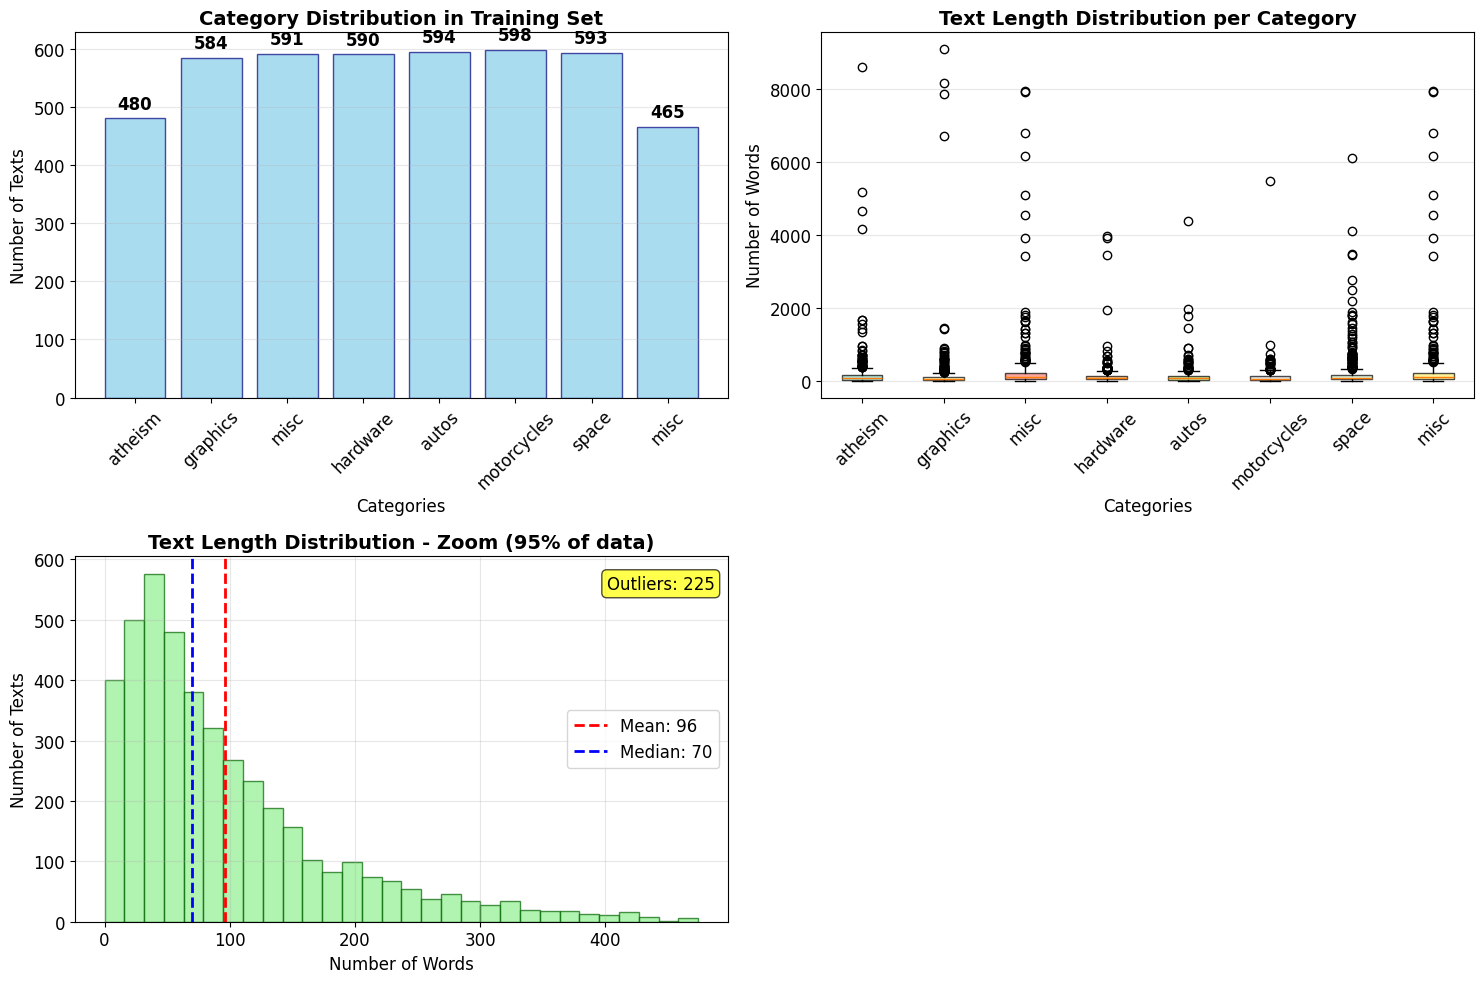

In [10]:
# visualizations
plt.figure(figsize=(15, 10))

# Chart 1: Category distribution
plt.subplot(2, 2, 1)
categories_short = [cat.split('.')[-1] for cat in newsgroups_train.target_names]
counts = [category_counts[i] for i in range(len(categories))]

bars = plt.bar(range(len(categories)), counts, color='skyblue', edgecolor='navy', alpha=0.7)
plt.title('Category Distribution in Training Set', fontsize=14, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Texts')
plt.xticks(range(len(categories)), categories_short, rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

# Chart 2: Box plot of lengths per category
plt.subplot(2, 2, 2)
category_lengths_list = [text_lengths_by_category[cat] for cat in categories_short]
box_plot = plt.boxplot(category_lengths_list, labels=categories_short, patch_artist=True)

# Coloring box plots
colors = plt.cm.Set3(np.linspace(0, 1, len(categories_short)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Text Length Distribution per Category', fontsize=14, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Number of Words')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Chart 3: Length histogram (zoomed)
plt.subplot(2, 2, 3)
percentile_95 = np.percentile(text_lengths, 95)
filtered_lengths = [length for length in text_lengths if length <= percentile_95]

plt.hist(filtered_lengths, bins=30, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
plt.title(f'Text Length Distribution - Zoom (95% of data)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')

plt.axvline(np.mean(filtered_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(filtered_lengths):.0f}')
plt.axvline(np.median(filtered_lengths), color='blue', linestyle='--', linewidth=2, 
            label=f'Median: {np.median(filtered_lengths):.0f}')

outliers_count = len(text_lengths) - len(filtered_lengths)
plt.text(0.98, 0.95, f'Outliers: {outliers_count}', 
         transform=plt.gca().transAxes, ha='right', va='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.legend()
plt.grid(alpha=0.3)

# Chart 4: Length analysis
plt.subplot(2, 2, 4)
plt.axis('off')

plt.tight_layout()
plt.show()


## Text preprocessing

In [11]:
def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

sample_text = "Hello WORLD!!! This is a test... with 123 numbers & special chars @#$%"
processed_text = preprocess_text(sample_text)

print(f"Before: {sample_text}")
print(f"After:  {processed_text}")

# Preprocessing all texts
print(f"\nPreprocessing {len(newsgroups_train.data)} training texts...")
X_train_raw = [preprocess_text(text) for text in newsgroups_train.data]

print(f"Preprocessing {len(newsgroups_test.data)} test texts...")
X_test_raw = [preprocess_text(text) for text in newsgroups_test.data]

y_train = newsgroups_train.target
y_test = newsgroups_test.target

print(f"   • Training texts: {len(X_train_raw)}")
print(f"   • Test texts: {len(X_test_raw)}")
processed_lengths = [len(text.split()) for text in X_train_raw]
print(f"   • Average length: {np.mean(processed_lengths):.0f} words")
print(f"   • Length reduction: {np.mean(text_lengths) - np.mean(processed_lengths):.0f} words")

Before: Hello WORLD!!! This is a test... with 123 numbers & special chars @#$%
After:  hello world this is a test with 123 numbers special chars

Preprocessing 4495 training texts...
Preprocessing 2992 test texts...
   • Training texts: 4495
   • Test texts: 2992
   • Average length: 159 words
   • Length reduction: 3 words


## TF-IDF VECTORIZATION

In [12]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,     # Top 10k most important words
    min_df=2,               # Word must occur at least 2 times
    max_df=0.95,            # Ignore words in >95% of documents
    stop_words='english',   # Remove English stop words
    ngram_range=(1, 2)      # Unigrams and bigrams
)

X_train_tfidf = vectorizer.fit_transform(X_train_raw)
X_test_tfidf = vectorizer.transform(X_test_raw)

print(f"TF-IDF matrix created!")
print(f"   • Training shape: {X_train_tfidf.shape}")
print(f"   • Test shape: {X_test_tfidf.shape}")
print(f"   • Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print(f"   • Sparsity: {(1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])):.3f}")


TF-IDF matrix created!
   • Training shape: (4495, 10000)
   • Test shape: (2992, 10000)
   • Vocabulary size: 10000
   • Sparsity: 0.995


## Word cloud

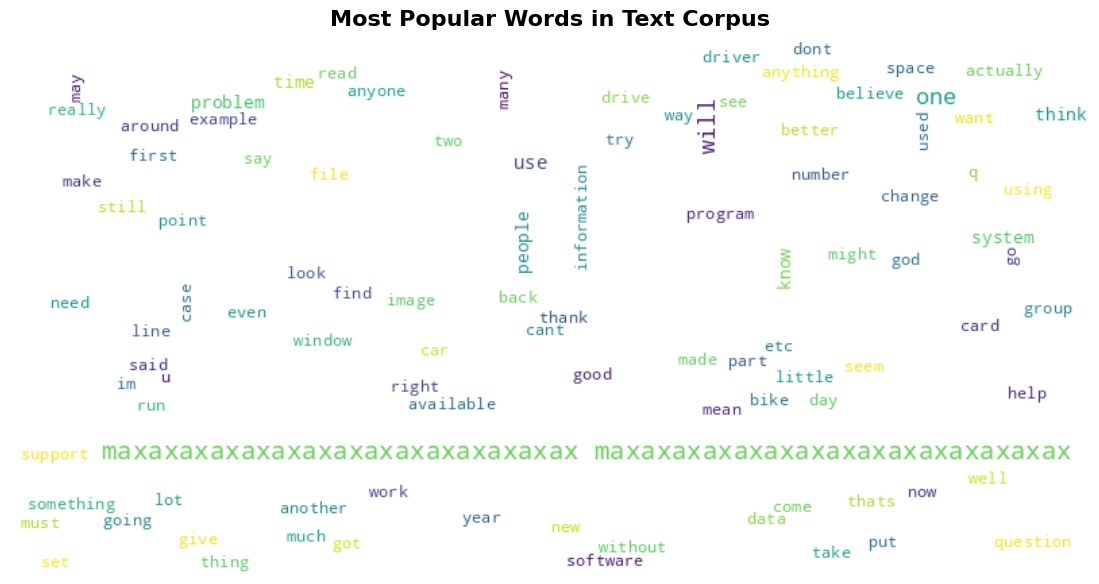

In [13]:
# Combine all texts
all_text = ' '.join(X_train_raw)

# Create word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=100,
    colormap='viridis',
    relative_scaling=0.5
).generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Popular Words in Text Corpus', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Model training

In [14]:
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        solver='lbfgs'
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        n_jobs=-1
    ),
    'SVM': SVC(
        kernel='linear', 
        random_state=42,
        probability=True
    )
}

print("ALGORITHMS TO TEST:")
for name, model in models.items():
    print(f"   • {name}")

# Training and evaluating models
results = {}
trained_models = {}

print(f"\nTRAINING MODELS...")
print("=" * 30)

for name, model in models.items():
    print(f"\nTraining: {name}")
    start_time = datetime.now()
    
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    
    # Save results
    results[name] = {
        'accuracy': accuracy,
        'predictions': y_pred,
        'training_time': training_time,
        'model': model
    }
    
    trained_models[name] = model
    
    print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    print(f"   Training time: {training_time:.2f}s")

ALGORITHMS TO TEST:
   • Logistic Regression
   • Random Forest
   • SVM

TRAINING MODELS...

Training: Logistic Regression
   Accuracy: 0.7470 (74.7%)
   Training time: 5.22s

Training: Random Forest
   Accuracy: 0.6865 (68.6%)
   Training time: 0.33s

Training: SVM
   Accuracy: 0.7279 (72.8%)
   Training time: 22.31s


## Model results comparison 

Model                Accuracy   Time [s]   Position
--------------------------------------------------
Logistic Regression  0.7470     5.22       1
SVM                  0.7279     22.31      2
Random Forest        0.6865     0.33       3

BEST MODEL: Logistic Regression
Accuracy: 0.7470
Time: 5.22s


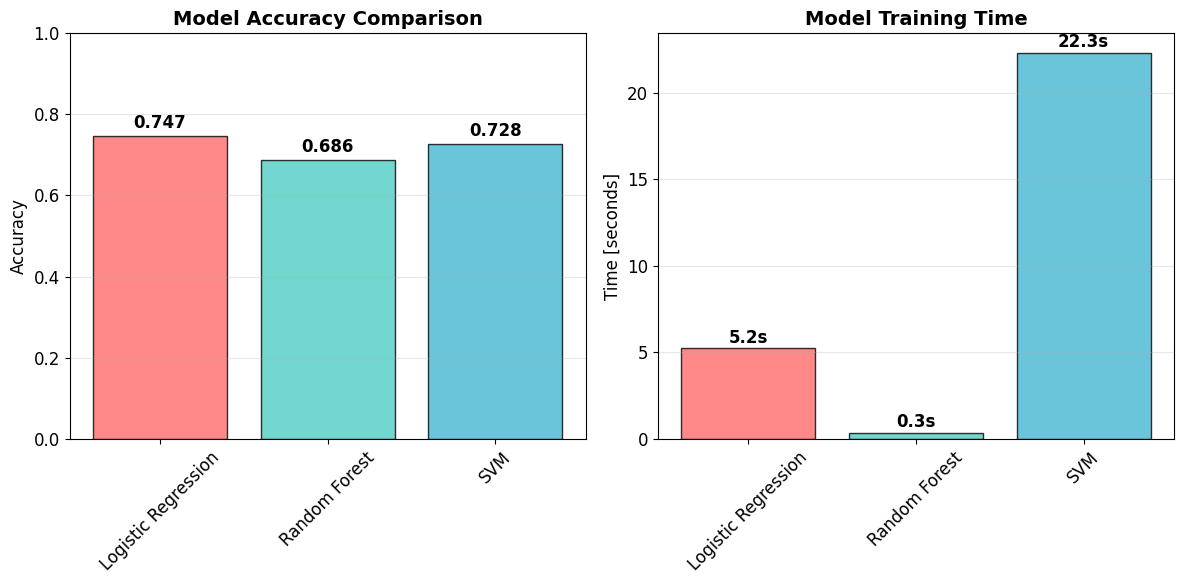

In [20]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

print(f"{'Model':<20} {'Accuracy':<10} {'Time [s]':<10} {'Position':<8}")
print("-" * 50)

for i, (name, data) in enumerate(sorted_results, 1):
    print(f"{name:<20} {data['accuracy']:<10.4f} {data['training_time']:<10.2f} {i}")

# Best model
best_model_name = sorted_results[0][0]
best_model_data = sorted_results[0][1]
best_model = best_model_data['model']

print(f"\nBEST MODEL: {best_model_name}")
print(f"Accuracy: {best_model_data['accuracy']:.4f}")
print(f"Time: {best_model_data['training_time']:.2f}s")

# Comparison chart
plt.figure(figsize=(12, 6))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = plt.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black')
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)

# Subplot 2: Training time
plt.subplot(1, 2, 2)
times = [results[name]['training_time'] for name in model_names]

bars2 = plt.bar(model_names, times, color=colors, alpha=0.8, edgecolor='black')
plt.title('Model Training Time', fontsize=14, fontweight='bold')
plt.ylabel('Time [seconds]')
plt.xticks(rotation=45)

# Add values on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Model evaluation 

CLASSIFICATION REPORT:
                          precision    recall  f1-score   support

             alt.atheism       0.73      0.71      0.72       319
           comp.graphics       0.75      0.75      0.75       389
 comp.os.ms-windows.misc       0.75      0.64      0.69       394
comp.sys.ibm.pc.hardware       0.81      0.78      0.80       392
               rec.autos       0.76      0.76      0.76       396
         rec.motorcycles       0.66      0.83      0.73       398
               sci.space       0.76      0.78      0.77       394
      talk.politics.misc       0.79      0.71      0.75       310

                accuracy                           0.75      2992
               macro avg       0.75      0.74      0.75      2992
            weighted avg       0.75      0.75      0.75      2992


CONFUSION MATRIX:


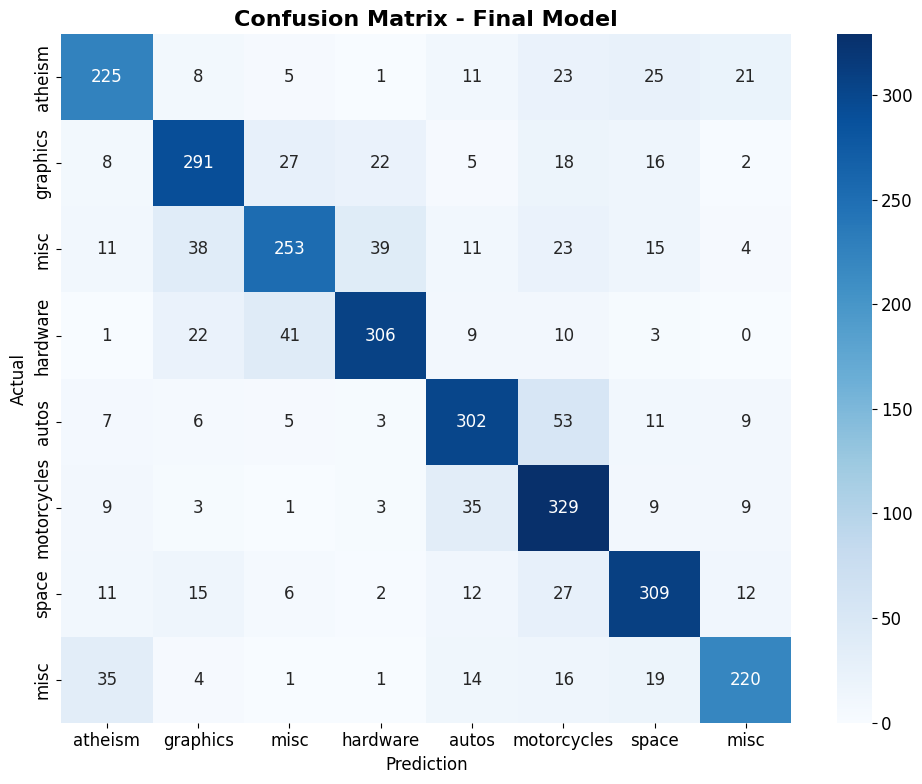


MOST COMMON CLASSIFICATION ERRORS:
Actual          →   Predicted       Errors  
---------------------------------------------
autos           → motorcycles     53      
hardware        → misc            41      
misc            → hardware        39      
misc            → graphics        38      
motorcycles     → autos           35      
misc            → atheism         35      
graphics        → misc            27      
space           → motorcycles     27      


In [16]:
final_model = best_model # linear regression
final_predictions = results[best_model_name]['predictions']
final_accuracy = results[best_model_name]['accuracy']

print("CLASSIFICATION REPORT:")

classification_rep = classification_report(
    y_test, 
    final_predictions, 
    target_names=newsgroups_test.target_names,
    output_dict=True
)

print(classification_report(
    y_test, 
    final_predictions, 
    target_names=newsgroups_test.target_names
))

# Confusion Matrix
cm = confusion_matrix(y_test, final_predictions)

print(f"\nCONFUSION MATRIX:")

# Confusion Matrix visualization
plt.figure(figsize=(10, 8))
category_names_short = [name.split('.')[-1] for name in newsgroups_test.target_names]

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_names_short,
            yticklabels=category_names_short)
plt.title('Confusion Matrix - Final Model', fontsize=16, fontweight='bold')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Error analysis
print(f"\nMOST COMMON CLASSIFICATION ERRORS:")

errors = []
for i in range(len(newsgroups_test.target_names)):
    for j in range(len(newsgroups_test.target_names)):
        if i != j and cm[i][j] > 0:
            errors.append((
                newsgroups_test.target_names[i].split('.')[-1],
                newsgroups_test.target_names[j].split('.')[-1], 
                cm[i][j]
            ))

errors.sort(key=lambda x: x[2], reverse=True)

print(f"{'Actual':<15} {'→':<3} {'Predicted':<15} {'Errors':<8}")
print("-" * 45)

for true_cat, pred_cat, count in errors[:8]:
    print(f"{true_cat:<15} → {pred_cat:<15} {count:<8}")


METRICS PER CATEGORY:
   Category  Precision  Recall  F1-Score
    atheism      0.733   0.705     0.719
   graphics      0.752   0.748     0.750
       misc      0.746   0.642     0.690
   hardware      0.812   0.781     0.796
      autos      0.757   0.763     0.760
motorcycles      0.659   0.827     0.734
      space      0.759   0.784     0.772
       misc      0.794   0.710     0.750


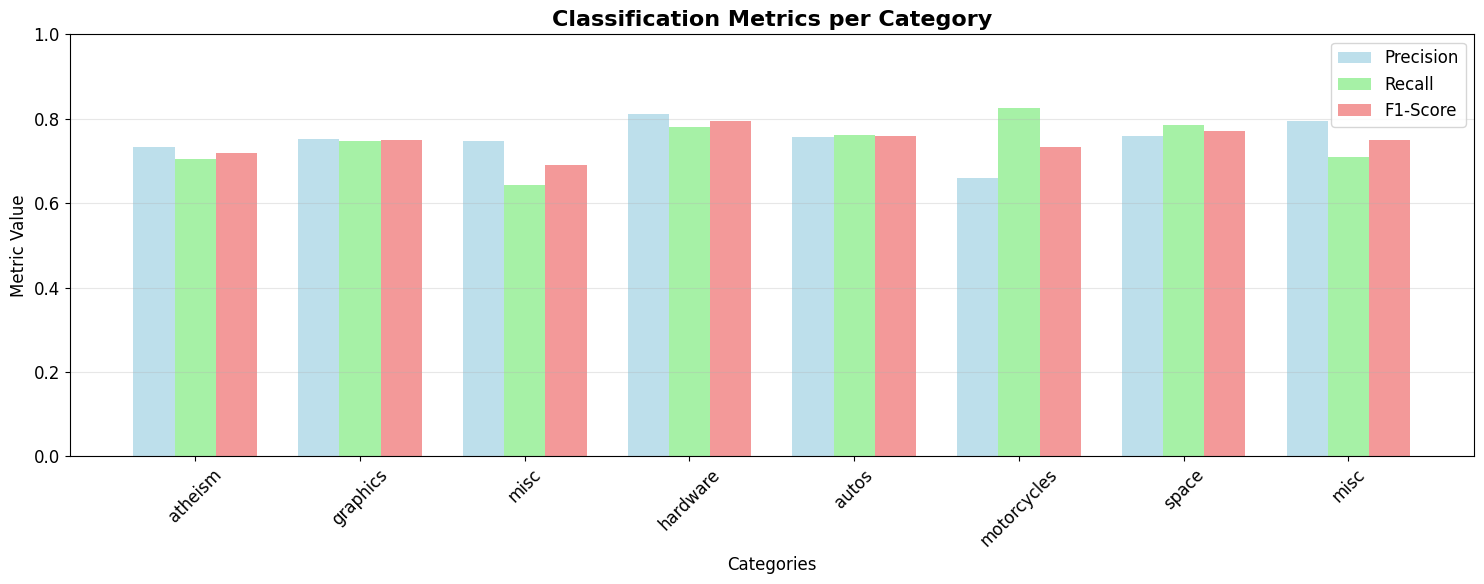

In [17]:
# Detailed metrics per category
print(f"\nMETRICS PER CATEGORY:")
print("=" * 30)

categories_short = [name.split('.')[-1] for name in newsgroups_test.target_names]
precisions = [classification_rep[cat]['precision'] for cat in newsgroups_test.target_names]
recalls = [classification_rep[cat]['recall'] for cat in newsgroups_test.target_names]
f1_scores = [classification_rep[cat]['f1-score'] for cat in newsgroups_test.target_names]

# DataFrame with metrics
metrics_df = pd.DataFrame({
    'Category': categories_short,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
})

print(metrics_df.round(3).to_string(index=False))

# Metrics chart per category
plt.figure(figsize=(15, 6))

x = np.arange(len(categories_short))
width = 0.25

plt.bar(x - width, precisions, width, label='Precision', color='lightblue', alpha=0.8)
plt.bar(x, recalls, width, label='Recall', color='lightgreen', alpha=0.8)
plt.bar(x + width, f1_scores, width, label='F1-Score', color='lightcoral', alpha=0.8)

plt.title('Classification Metrics per Category', fontsize=16, fontweight='bold')
plt.xlabel('Categories')
plt.ylabel('Metric Value')
plt.xticks(x, categories_short, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

## Prediction function

In [18]:
def predict_text_tags(text, model=final_model, vectorizer=vectorizer, 
                     categories=newsgroups_test.target_names):
    processed_text = preprocess_text(text)
    
    text_vector = vectorizer.transform([processed_text])
    
    prediction = model.predict(text_vector)[0]
    probabilities = model.predict_proba(text_vector)[0]
    
    top_3_indices = probabilities.argsort()[-3:][::-1]
    
    results = {
        'text_length': len(text.split()),
        'processed_length': len(processed_text.split()),
        'main_tag': categories[prediction],
        'main_tag_short': categories[prediction].split('.')[-1],
        'confidence': float(probabilities[prediction]),
        'top_3_tags': [
            {
                'tag': categories[idx],
                'tag_short': categories[idx].split('.')[-1],
                'probability': float(probabilities[idx])
            }
            for idx in top_3_indices
        ]
    }
    
    return results


## Testing

TESTING ON 6 SAMPLE TEXTS:

TEXT 1:
   I just bought a new car with amazing acceleration and great fuel economy. The engine performance is outstanding and the handling is smooth.

RESULTS:
   • Main tag: autos (confidence: 0.733)
   • Text length: 23 words
   • Top 3 predictions:
     1 autos: 0.733
     1 motorcycles: 0.081
     1 space: 0.045
--------------------------------------------------

TEXT 2:
   The latest graphics card from NVIDIA has incredible performance for gaming and machine learning applications. The ray tracing capabilities are impressive.

RESULTS:
   • Main tag: graphics (confidence: 0.484)
   • Text length: 21 words
   • Top 3 predictions:
     2 graphics: 0.484
     2 misc: 0.130
     2 hardware: 0.116
--------------------------------------------------

TEXT 3:
   NASA announced a new mission to Mars next year. The spacecraft will carry advanced scientific instruments to study the planet's atmosphere and geology.

RESULTS:
   • Main tag: space (confidence: 0.747)

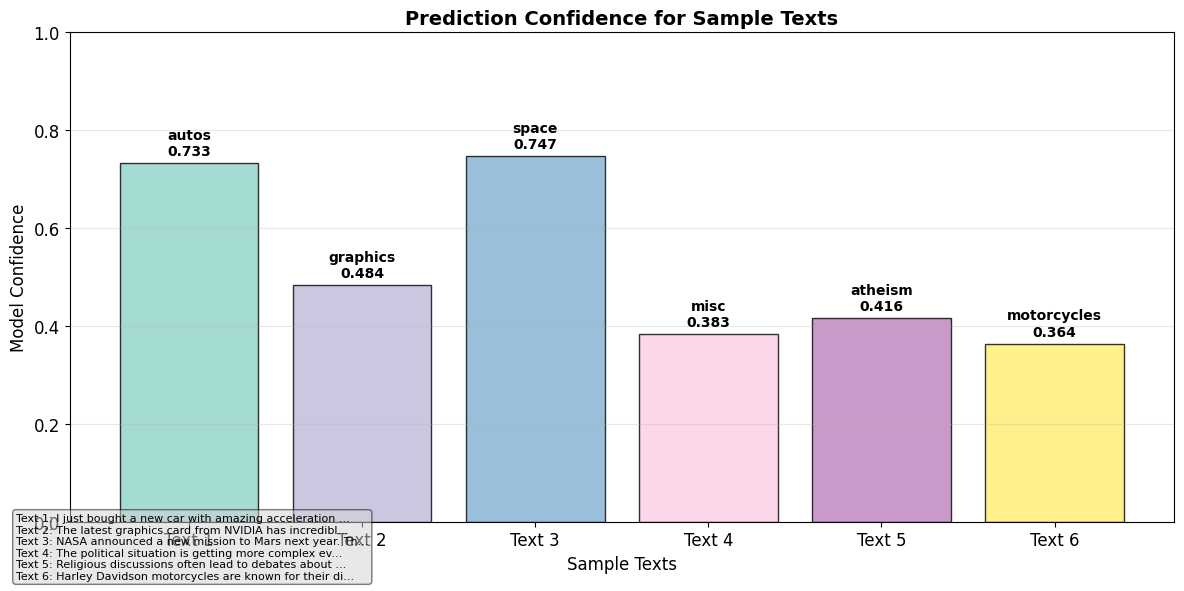

In [22]:
# Sample texts for testing
test_texts = [
    "I just bought a new car with amazing acceleration and great fuel economy. The engine performance is outstanding and the handling is smooth.",
    
    "The latest graphics card from NVIDIA has incredible performance for gaming and machine learning applications. The ray tracing capabilities are impressive.",
    
    "NASA announced a new mission to Mars next year. The spacecraft will carry advanced scientific instruments to study the planet's atmosphere and geology.",
    
    "The political situation is getting more complex every day with new policies being announced. The government needs to address these issues carefully.",
    
    "Religious discussions often lead to debates about faith versus scientific evidence and rational thinking. Many people question traditional beliefs.",
    
    "Harley Davidson motorcycles are known for their distinctive sound and classic American design. The chrome finish and powerful engine make them iconic."
]

print(f"TESTING ON {len(test_texts)} SAMPLE TEXTS:")
print("=" * 55)

predictions_data = []

for i, text in enumerate(test_texts, 1):
    print(f"\nTEXT {i}:")
    print(f"   {text}")
    
    result = predict_text_tags(text)
    
    print(f"\nRESULTS:")
    print(f"   • Main tag: {result['main_tag_short']} (confidence: {result['confidence']:.3f})")
    print(f"   • Text length: {result['text_length']} words")
    
    print(f"   • Top 3 predictions:")
    for j, tag_info in enumerate(result['top_3_tags'], 1):
        print(f"     {i} {tag_info['tag_short']}: {tag_info['probability']:.3f}")
    
    predictions_data.append({
        'text': text[:50] + "..." if len(text) > 50 else text,
        'predicted_tag': result['main_tag_short'],
        'confidence': result['confidence']
    })
    
    print("-" * 50)

# Visualization of predictions
plt.figure(figsize=(12, 6))
pred_texts = [pred['text'] for pred in predictions_data]
pred_tags = [pred['predicted_tag'] for pred in predictions_data]
pred_conf = [pred['confidence'] for pred in predictions_data]

colors = plt.cm.Set3(np.linspace(0, 1, len(pred_texts)))
bars = plt.bar(range(len(pred_texts)), pred_conf, color=colors, alpha=0.8, edgecolor='black')

plt.title('Prediction Confidence for Sample Texts', fontsize=14, fontweight='bold')
plt.xlabel('Sample Texts')
plt.ylabel('Model Confidence')
plt.xticks(range(len(pred_texts)), [f"Text {i+1}" for i in range(len(pred_texts))])

# Add tags on bars
for i, (bar, tag, conf) in enumerate(zip(bars, pred_tags, pred_conf)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{tag}\n{conf:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Legend with texts
legend_labels = [f"Text {i+1}: {text}" for i, text in enumerate(pred_texts)]
plt.figtext(0.02, 0.02, '\n'.join(legend_labels), fontsize=8, 
           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

plt.tight_layout()
plt.show()

## Model saving

In [24]:
import os
os.makedirs('models', exist_ok=True)

model_filename = 'models/text_classifier_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved: {model_filename}")

vectorizer_filename = 'models/tfidf_vectorizer.pkl'
joblib.dump(vectorizer, vectorizer_filename)
print(f"Vectorizer saved: {vectorizer_filename}")

metadata = {
    'model_name': best_model_name,
    'final_accuracy': final_accuracy,
    'categories': newsgroups_test.target_names,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train_raw),
    'test_samples': len(X_test_raw),
    'vocabulary_size': len(vectorizer.get_feature_names_out()),
    'classification_report': classification_rep,
    'confusion_matrix': cm.tolist(),
    'model_comparison': {name: data['accuracy'] for name, data in results.items()},
    'preprocessing_info': {
        'tfidf_params': {
            'max_features': vectorizer.max_features,
            'min_df': vectorizer.min_df,
            'max_df': vectorizer.max_df,
            'ngram_range': vectorizer.ngram_range
        }
    }
}

metadata_filename = 'models/model_metadata.pkl'
with open(metadata_filename, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Metadata saved: {metadata_filename}")

Model saved: models/text_classifier_model.pkl
Vectorizer saved: models/tfidf_vectorizer.pkl
Metadata saved: models/model_metadata.pkl
